# Subtract cancellation
When the subtracted value (a-b) is too small to a or b, the floating number presicion error due to the storage size limit become not-negligible.

## Example

Logistic log loss $-(Tlog(Z) + (1-T)log(1-Z)$ where $Z=sigmoid(X)$. ```X``` is a batch input data of x and ```T``` are binary labels 0/1 for each x.

When T=0, the numeric gradient ```(f(x+k)-f(x-k))/2k``` is expected to be similar to the analytical gradient of ```df/dx = Z```, which is the derivative of ```f(X) = -log(1-sigmoid(X))```. With ```Z=sigmoid(X)```, ```df(x)/dx = df(z)/dz * dz/dx = -1/(1-Z) * -Z(1-Z) = Z```.  The derivative of log(x) = 1/x and derivative of z=sigmoid(x) is z(1-z). When X is around 12.5, z=sigmoid(X) is almost 1 (0.9999962733607158), hence the gradient Z=1 is expected when T=0.

However, the numerica gradient gets unstable for ```log(1-sigmoid(X))``` when the delta ```k``` gets smaller  approximately ```1e-8```. However, ```log(sigmoid(X))``` does not show such unstability. 


<img src="image/subtract_cancellation_logistic_log_loss_gradient_diverge.png" align="left">


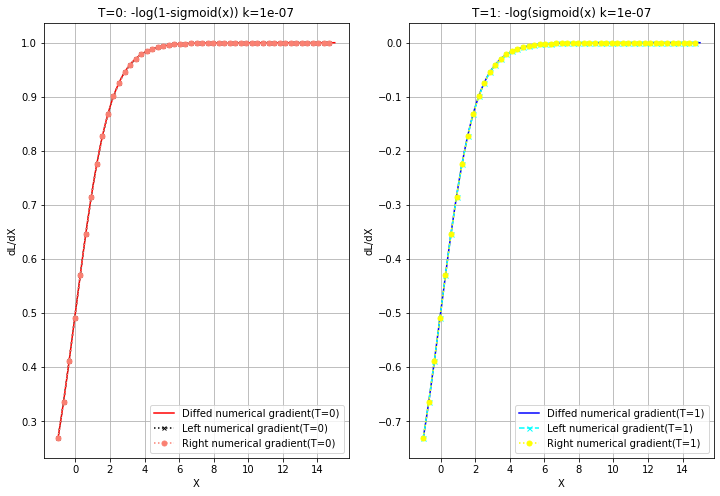

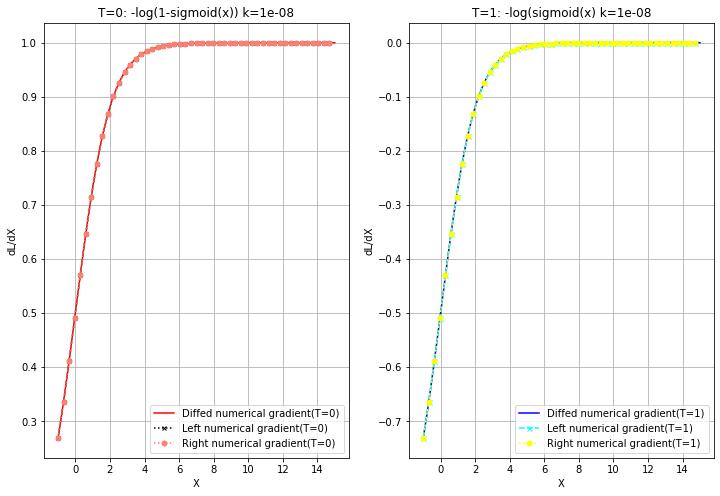

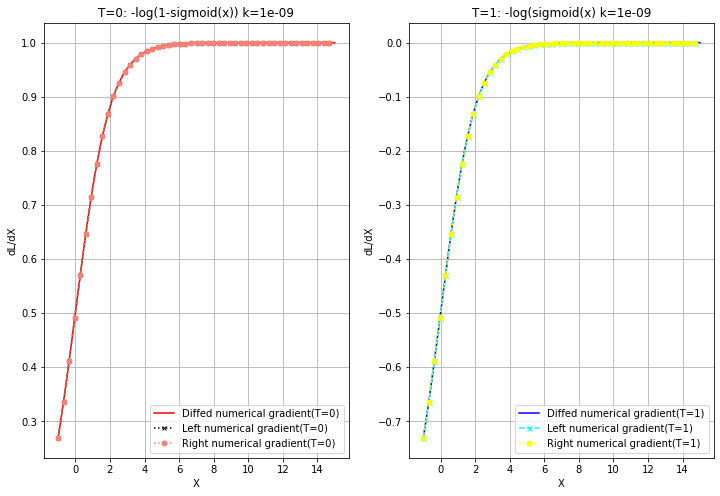

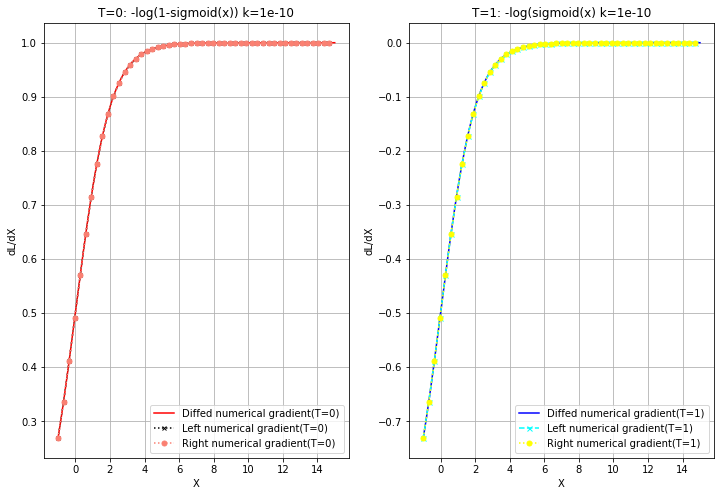

In [1]:
import inspect
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def __sigmoid(X):
    return 1 / (1 + np.exp(-1 * X))

def __sigmoid_reverse(y):
    """
    Args:
        y: y=sigmoid(x)
    Returns:
        x: x that gives y=sigmoid(x)
    """
    return np.log(y/(1-y))

def __sigmoid_gradient(X):
    Z = __sigmoid(X)
    return Z * (1.0 - Z)

def __logistic_log_loss(X: np.ndarray, T: np.ndarray, offset: float=0):
    return -(T * np.log(__sigmoid(X)+offset) + (1-T) * np.log(1-__sigmoid(X)+offset))

def __logistic_log_loss_gradient(X, T):
    Z = __sigmoid(X)
    return Z-T

def __numerical_jacobian(f, X, delta=1e-8) -> np.ndarray:
    X = np.array(X, dtype=float) if isinstance(X, (float, int)) else X
    J = np.zeros_like(X, dtype=float)
    assert (X.dtype == float), "X must be float type"
    assert delta > 0.0

    it = np.nditer(X, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp: float = X[idx]

        X[idx] = tmp + delta
        fx1: Union[np.ndarray, float] = f(X)  # f(x+h)

        assert not np.all(np.isnan(fx1)), \
            "numerical delta f(x+h) caused nan for f %s for X %s" \
            % (f, (tmp + delta))

        X[idx] = tmp - delta
        fx2: Union[np.ndarray, float] = f(X)  # f(x-h)
        assert not np.all(np.isnan(fx2)), \
            "numerical delta f(x-h) caused nan for f %s for X %s" \
            % (f, (tmp - delta))

        g: Union[np.ndarray, float] = (fx1 - fx2) / (2 * delta)
        assert (isinstance(g, np.ndarray) and g.size == 1) or isinstance(g, float), \
            "The f function needs to return scalar or shape () but %s" % g
        J[idx] = g
        X[idx] = tmp
        it.iternext()

    return J

def __gn(X, t, k):
    """Numerical gradient for logistic log loss"""
    return [
        __numerical_jacobian(lambda x: __logistic_log_loss(X=x, T=t, offset=k), x) 
        for x in X 
    ]

def t_0_loss(X):
    return [
        #logistic_log_loss(P=sigmoid(x), T=0)
        #-np.log(1.0 - __sigmoid(x)) for x in X
        -np.log(np.exp(-x)) + np.log(1+np.exp(-x)) for x in X
        
    ]

def t_1_loss(X):
    return [
        #logistic_log_loss(P=sigmoid(x), T=1)
        -np.log(__sigmoid(x)) for x in X 
    ]


def gn_plot(X, k):
    fig, axes = plt.subplots(1, 2, figsize=(12,8))

    # --------------------------------------------------------------------------------
    # T = 0
    # --------------------------------------------------------------------------------
    axes[0].plot(
        X,
        ((np.array(t_0_loss(X + k)) - np.array(t_0_loss(X - k))) / (2*k)),
        color='red', linestyle='solid',
        label="Diffed numerical gradient(T=0)"
    )
    axes[0].plot(
        X[0:-1:20],
        ((np.array(t_0_loss(X + k)) - np.array(t_0_loss(X))) / k)[0:-1:20],
        color='black', linestyle='dotted', marker='x', markersize=4,
        label="Left numerical gradient(T=0)"
    )
    axes[0].plot(
        X[0:-1:20],
        ((np.array(t_0_loss(X)) - np.array(t_0_loss(X - k))) / k)[0:-1:20],
        color='salmon', linestyle='dotted', marker='o', markersize=5,
        label="Right numerical gradient(T=0)"
    )

    axes[0].set_xlabel("X")
    axes[0].set_ylabel("dL/dX")
    axes[0].set_title(f"T=0: -log(1-sigmoid(x)) k={k}")
    axes[0].legend()
    axes[0].grid(True)

    # --------------------------------------------------------------------------------
    # T = 1
    # --------------------------------------------------------------------------------
    axes[1].plot(
        X,
        ((np.array(t_1_loss(X + k)) - np.array(t_1_loss(X - k))) / (2*k)),
        color='blue', linestyle='solid',
        label="Diffed numerical gradient(T=1)"
    )
    axes[1].plot(
        X[0:-1:20],
        ((np.array(t_1_loss(X + k)) - np.array(t_1_loss(X))) / k)[0:-1:20],
        color='cyan', linestyle='dashed', marker='x', markersize=5,
        label="Left numerical gradient(T=1)"
    )
    axes[1].plot(
        X[0:-1:20],
        ((np.array(t_1_loss(X)) - np.array(t_1_loss(X - k))) / k)[0:-1:20],
        color='yellow', linestyle='dotted', marker='o', markersize=5,
        label="Right numerical gradient(T=1)"
    )

    axes[1].set_xlabel("X")
    axes[1].set_ylabel("dL/dX")
    axes[1].set_title(f"T=1: -log(sigmoid(x) k={k}")
    axes[1].legend()
    axes[1].grid(True)

    
N = 500
left=-20
right=20

N = 1000
left=-1
right=15

# Numerical gradient
# (f(x+k)-f(x-k)) / 2h 

K = [1e-7, 1e-8, 1e-9, 1e-10]
X = np.linspace(left,right,N)

for k in K:
    gn_plot(X, k)

    

---

# Considerations

* [2.4 Weaknesses with Floating-point Numbers](https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/)
> Because we are attempting to represent an infinite number of different real numbers with a finite number of floating-point numbers, we must run into problems.

The precision of the float number is constrained by its storage size. IEEE format gives 64 bits and any real numbers are rounded to fit into the storage size to be represented in a binary format. Due to this constraint, float numbers can cause unexpected results. Hence, need to be aware of the potential issues, their mechanisms, and how to avoid them.

<img src="image/IEEE754_float_format.png" align="left">



## Rounding Error
For instance, ```3 * 0.1``` is not 0.3.

In [2]:
print(3 * 0.1 == 0.3)     # False
print(0.3 * 1 == 0.3)     # True
print(1 * 0.1 == 0.1)     # True
print(1/10 == 0.1)        # True
print(0.3 * 0.1 == 0.03)  # True

False
True
True
True
True


Because 0.1 cannot be represented in a binary format with 64 bits and 0.1 is actually ```0.1000000000000000055511151231257827021181583404541015625```. 

In [3]:
print("0.1 is actually %0.55f" % (1.0 / 10))
print(f"0.1000000000000000055511151231257827021181583404541015625 == 0.1 is {0.1000000000000000055511151231257827021181583404541015625 == 0.1}")
print(f"(0.1-0.3/3) is {0.1 - 0.3/3}")

0.1 is actually 0.1000000000000000055511151231257827021181583404541015625
0.1000000000000000055511151231257827021181583404541015625 == 0.1 is True
(0.1-0.3/3) is 1.3877787807814457e-17


## Subtractive Cancellation

* [2.4 Weaknesses with Floating-point Numbers](https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/)

> The easiest example is with the formula for the derivative: ```(f(x + h) - f(x))/h```. If we use ```f(x) = x**2``` with x = 3.253 and h = 0.002, we get an approximation ```(3.2552 - 3.2532)/0.002 = (10.60 - 10.58)/0.002 = 10```., which is a poor approximation for the actual derivative 6.506.

---

## Using Big Integer

Python handles int/big-int transparently.

* [Handling very large numbers in Python](https://stackoverflow.com/a/538583/4281353)

> as long as you have version 2.5 or better, just perform standard math operations and any number which exceeds the boundaries of 32-bit math will be automatically (and transparently) converted to a bignum. You can find all the gory details in PEP 0237.